# Notebook 4: Linear Regression (Ising)

## Learning Goal
Let us now apply linear regression to an example that is familiar from Statistical Mechanics: the Ising model. The goal of this notebook is to revisit the concepts of in-sample and out-of-sample errors, as well as $L2$- and $L1$-regularization, in an example that is more intuitive to physicists. 

## Overview
Consider the 1D Ising model with nearest-neighbor interactions 

$$H[\boldsymbol{S}]=-J\sum_{j=1}^L S_{j}S_{j+1}$$

on a chain of length $L$ with periodic boundary conditions and $S_j=\pm 1$ Ising spin variables. In one dimension, this paradigmatic model has no phase transition at finite temperature. 


### Exercises (optional): ###  
We invite the reader who is unfamiliar with the property of the Ising model to solve the following problems.
<ul>
<li> Compute the partition function of the Ising model in one dimension at inverse temperature $\beta$ when $L\rightarrow\infty$ (thermodynamic limit):
    $$Z=\sum_S \exp(-\beta H[S]).$$
Here the sum is carried over all $2^L$ spin configurations.
<li> Compute the model's magnetization $M=\langle\sum_i S_i\rangle$ in the same limit ($L\rightarrow\infty$). The expectation is taken with respect to the Boltzmann distribution:
    $$p(S)=\frac{\exp(-\beta H[S])}{Z}$$
    -$$ M = \frac{1}{L} \cdot \frac{1}{Z} \cdot \sum_{i=1}^{L} S_i \exp\left(-\beta H[S_i]\right) $$
<li> How does $M$ behave as a function of the temperature $T=\beta^{-1}$?
    
    The relation y=exp(-1/x) approaches y=1 as x goes to infinity.
    As T goes to infinity, beta goes to 0, and the exponential term becomes 1.
    So now M = (1/L) * (1/Z) * sum(S_i), which is the mean value of the spins in the system.
    With spins being \pm1, this makes a mean of 0. So, with higher T, we get lower M.
</ul>

For a more detailed introduction we refer the reader to consult one of the many textbooks on the subject (see for instance <a href="https://www.amazon.com/Lectures-Transitions-Renormalization-Frontiers-Physics/dp/0201554097">Goldenfeld</a>, <a href="https://www.google.com/search?q=lubensky+condensed+matter+physics&rlz=1C5CHFA_enCA776CA776&oq=lubensky+&aqs=chrome.2.69i57j0l5.3047j1j7&sourceid=chrome&ie=UTF-8">Lubensky</a>, <a href="https://physics.anu.edu.au/theophys/baxter_book.php">Baxter </a>, etc.).

### Learning the Ising model ###

Suppose your boss set $J=1$, drew a large number of spin configurations, and computed their Ising energies. Then, without telling you about the above Hamiltonian, he or she handed you a data set of $i=1\ldots n$ points of the form $\{(H[\boldsymbol{S}^i],\boldsymbol{S}^i)\}$. Your task is to learn the Hamiltonian using Linear regression techniques. 

In [1]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model params
# system size
L=40

# create 10000 random Ising states
states=np.random.choice([-1, 1], size=(10000,L))

def ising_energies(states):
    """
    This function calculates the energies of the states in the nn Ising Hamiltonian
    """
    L = states.shape[1]
    J = np.zeros((L, L),)
    for i in range(L): 
        J[i,(i+1)%L]=-1.0 # interaction between nearest-neighbors
        
    # compute energies
    E = np.einsum('...i,ij,...j->...',states,J,states)

    return E
# calculate Ising energies
energies=ising_energies(states)

## Recasting the problem as a Linear Regression
First of all, we have to decide on a model class (possible Hamiltonians) we use to fit the data. In the absence of any prior knowledge, one sensible choice is the all-to-all Ising model

$$
H_\mathrm{model}[\boldsymbol{S}^i] = - \sum_{j=1}^L \sum_{k=1}^L J_{j,k}S_{j}^iS_{k}^i.
$$
Notice that this model is uniquely defined by the non-local coupling strengths $J_{jk}$ which we want to learn. Importantly, this model is linear in ${\mathbf J}$ which makes it possible to use linear regression.

To apply linear regression, we would like to recast this model in the form
$$
H_\mathrm{model}^i \equiv \mathbf{X}^i \cdot \mathbf{J},
$$

where the vectors $\mathbf{X}^i$ represent all two-body interactions $\{S_{j}^iS_{k}^i \}_{j,k=1}^L$, and the index $i$ runs over the samples in the data set. To make the analogy complete, we can also represent the dot product by a single index $p = \{j,k\}$, i.e. $\mathbf{X}^i \cdot \mathbf{J}=X^i_pJ_p$. Note that the regression model does not include the minus sign, so we expect to learn negative $J$'s.

In [2]:
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,energies]

## Numerical Experiments

As we already mentioned a few times in the review, learning is not fitting: the subtle difference is that once we fit the data to obtain a candidate model, we expect it to generalize to unseen data not used for the fitting procedure. For this reason, we begin by specifying a training and test data sets

In [52]:
# define number of samples
n_samples=300
# noise = True
noise = False
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2]
Y_test=Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

# Evaluating the performance:  coefficient of determination $R^2$

In what follows the model performance (in-sample and out-of-sample) is evaluated using the so-called coefficient of determination, which is given by:
\begin{align}
R^2 &= \left(1-\frac{u}{v}\right),\\
u&=(y_{pred}-y_{true})^2\\
v&=(y_{true}-\langle y_{true}\rangle)^2
\end{align}

The best possible score is 1.0 but it can also be negative. A constant model that always predicts the expected value of $y$, $\langle y_{true}\rangle$, disregarding the input features, would get a $R^2$ score of 0.

## Applying OLS, Ridge regression and LASSO:

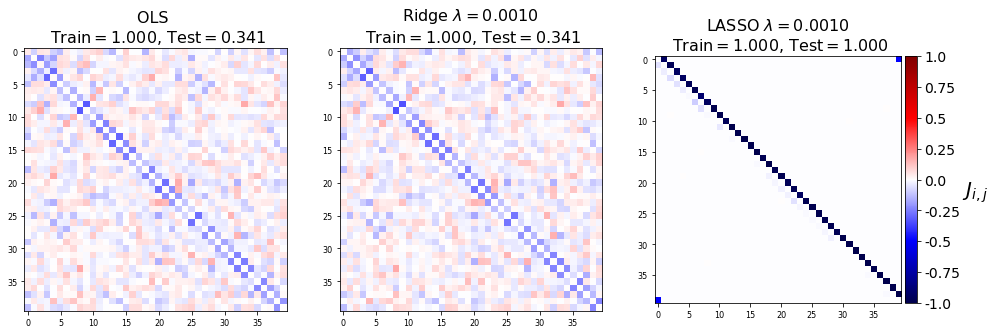

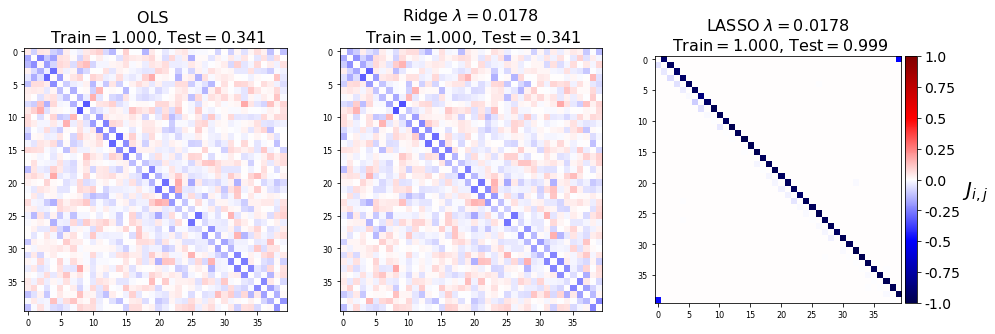

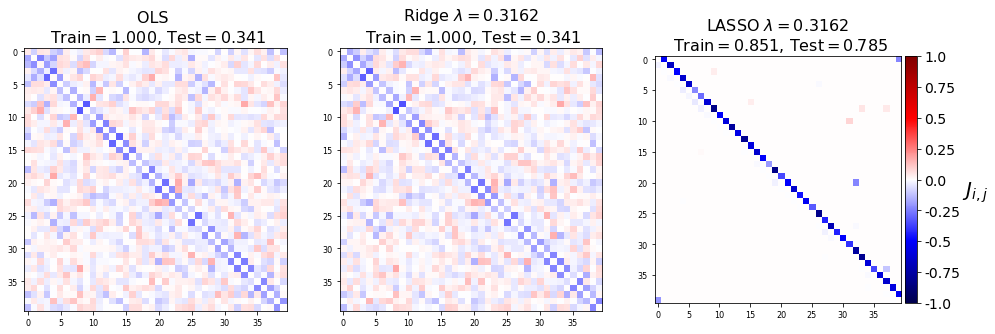

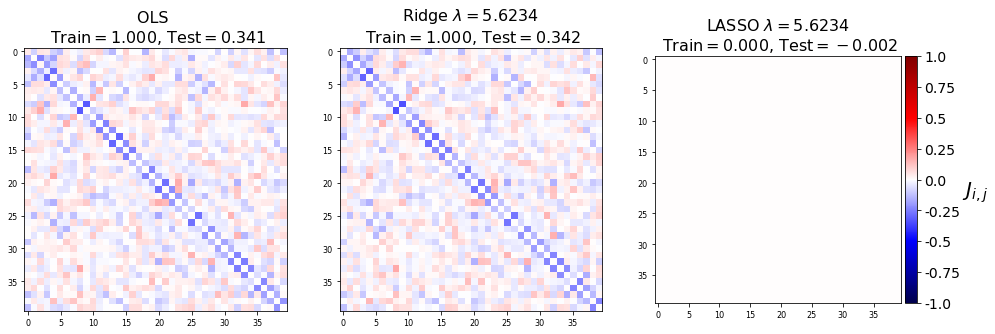

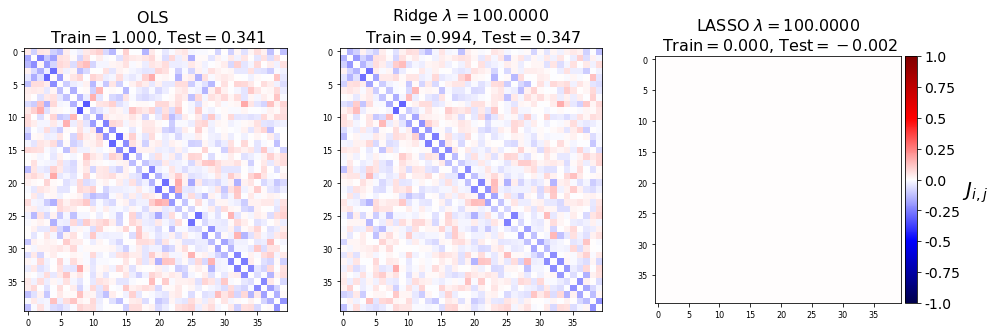

In [53]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []

train_errors_ridge = []
test_errors_ridge = []

train_errors_lasso = []
test_errors_lasso = []

# set regularisation strength values
lmbdas = np.logspace(-3, 2, 5)

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

for lmbda in lmbdas:
    
    ### ordinary least squares
    leastsq.fit(X_train, Y_train) # fit model 
    coefs_leastsq.append(leastsq.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_leastsq.append(leastsq.score(X_train, Y_train))
    test_errors_leastsq.append(leastsq.score(X_test,Y_test))
    
    ### apply RIDGE regression
    ridge.set_params(alpha=lmbda) # set regularisation parameter
    ridge.fit(X_train, Y_train) # fit model 
    coefs_ridge.append(ridge.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, Y_train))
    test_errors_ridge.append(ridge.score(X_test,Y_test))
    
    ### apply LASSO regression
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))

    ### plot Ising interaction J
    J_leastsq=np.array(leastsq.coef_).reshape((L,L))
    J_ridge=np.array(ridge.coef_).reshape((L,L))
    J_lasso=np.array(lasso.coef_).reshape((L,L))

    cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

    fig, axarr = plt.subplots(figsize=(16,10), nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq,**cmap_args)
    axarr[0].set_title('OLS \n Train$=%.3f$, Test$=%.3f$'%(train_errors_leastsq[-1], test_errors_leastsq[-1]),fontsize=16)
    axarr[0].tick_params(labelsize=8)
    
    axarr[1].imshow(J_ridge,**cmap_args)
    axarr[1].set_title('Ridge $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lmbda,train_errors_ridge[-1],test_errors_ridge[-1]),fontsize=16)
    axarr[1].tick_params(labelsize=8)
    
    im=axarr[2].imshow(J_lasso,**cmap_args)
    axarr[2].set_title('LASSO $\lambda=%.4f$\n Train$=%.3f$, Test$=%.3f$' %(lmbda,train_errors_lasso[-1],test_errors_lasso[-1]),fontsize=16)
    axarr[2].tick_params(labelsize=8)
    
    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05, add_to_figure=True)
    cbar=fig.colorbar(im, cax=cax)
    
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{i,j}$',labelpad=15, y=0.5,fontsize=20,rotation=0)
    
#     fig.subplots_adjust(right=2.0)
        
    if noise:
        plt.savefig('J_dists_{}+noise.png'.format(n_samples))
    else:
        plt.savefig('J_dists_{}.png'.format(n_samples))
    
    plt.show()

To quantify learning, we also plot the in-sample and out-of-sample errors

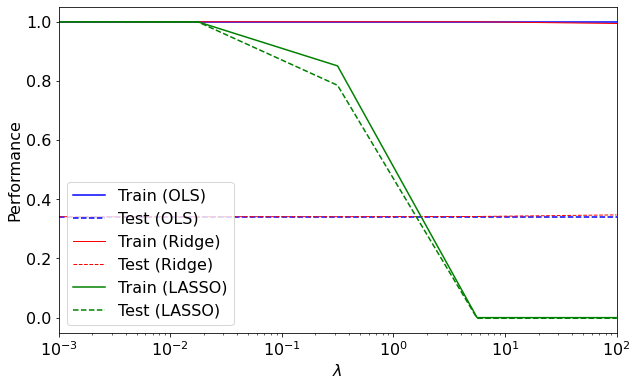

In [54]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_errors_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_errors_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_errors_ridge,'r',label='Train (Ridge)',linewidth=1)
plt.semilogx(lmbdas, test_errors_ridge,'--r',label='Test (Ridge)',linewidth=1)
plt.semilogx(lmbdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_errors_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
# plt.ylim([-0.1, 1.1])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('Performance',fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

## Understanding the results

Let us make a few remarks: 

(i) the inverse (see [Scikit documentation](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)) regularization parameter $\lambda$ affects the Ridge and LASSO regressions at scales, separated by a few orders of magnitude. Notice that this is different for the data considered in Notebook 3 __Section VI: Linear Regression (Diabetes)__. Therefore, it is considered good practice to always check the performance for the given model and data with $\lambda$ over multiple decades. 

(ii) at $\lambda\to 0$ and $\lambda\to\infty$, all three models overfit the data, as can be seen from the deviation of the test errors from unity (dashed lines), while the training curves stay at unity. 

(iii) While the OLS and Ridge regression test curves are monotonic, the LASSO test curve is not -- suggesting the optimal LASSO regularization parameter is $\lambda\approx 10^{-2}$. At this sweet spot, the Ising interaction weights ${\bf J}$ contain only nearest-neighbor terms (as did the model the data was generated from).

__Gauge degrees of freedom__: recall that the uniform nearest-neighbor interactions strength $J_{j,k}=J$ which we used to generate the data was set to unity, $J=1$. Moreover, $J_{j,k}$ was NOT defined to be symmetric (we only used the $J_{j,j+1}$ but never the $J_{j,j-1}$ elements). The colorbar on the matrix elements plot above suggest that the OLS and Ridge regression learn uniform symmetric weights $J=-0.5$. There is no mystery since this amounts to taking into account both the $J_{j,j+1}$ and the $J_{j,j-1}$ terms, and the weights are distributed symmetrically between them. LASSO, on the other hand, can break this symmetry (see matrix elements plots for $\lambda=0.001$ and $\lambda=0.01$). Thus, we see how different regularization schemes can lead to learning equivalent models but in different gauges. Any information we have about the symmetry of the unknown model that generated the data has to be reflected in the definition of the model and the regularization chosen.

### Exercises: ###  
<ul>
<li> Plot a histogram of the distribution of the components of ${\bf J}$ at different values of the number of training sample (one can go up to $2\times 10^4$). What happens with the sampling noise as the number of samples is increased/decreased for the three types of regression considered? How do the matrix elements plots above change?
    
    - When the sampling noise is increased by setting n_samples=40, ridge regression
      looks the same as OLS. Both severely overfit the data. LASSO performs even
      worse; it doesn't even begin to find the line around J=1. By the time 
      n_samples=300, though, LASSO performs well whereas OLS and ridge still overfit
      the data.
    - When data noise=0, going up to n_samples=4000 makes R^2=1 for all three models.
      OLS still has a lot of noise throughout the parameter space, whereas 
      ridge and LASSO just have the diagonal lines with significant power.
      LASSO seems to perform the best even at n_samples=400.
    - When data noise is added, the overall performances decrease as expected.

<li> Try to learn the underlying model of the data, assuming it lies within the class of one-body Hamiltonians, i.e. make the ansatz 
$$H_\mathrm{model}[\boldsymbol{S}^i] = \sum_{j=1}^L h_jS_{j}$$
for some unknown field $h_j$. How well can you explain the data? How well does the model generalize? Study these problems by playing with the size of the data set. Try out all three regression models and determine which one does the best. What is the relationship to Mean-Field Theory of this model?
    
    - The field $h_j$ is a self-consistent mean field that accounts for the
      interactions between spins. The effective magnetic field that acts
      on each spin is the sum of the external magnetic field and the 
      mean field $h_j$.
    
</ul>

In [24]:
import numpy as np
import scipy.sparse as sp
np.random.seed(12)


import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

### define Ising model params
# system size
L=400

# create 10000 random Ising states
# states=np.random.choice([-1, 1], size=(40,L))
states = np.random.choice([-1, 1], size=L)

def ansatz(states):
    """
    I didn't get this working correctly. I guess I needed to take into account the
    i subscript and not just the j subscript?...
    This function calculates the energies for the states in the above Hamiltonian
    """
    # L = states.shape[1]
    # h = np.zeros((L, L),)
    h = np.random.randn(L)
    S = np.random.choice([-1, 1], size=L)
    # for i in range(L): 
        # h[i,(i+1)%L]=-1.0 # interaction between nearest-neighbors
        
    # compute energies
    # E = np.einsum('...i,ij,...j->...',states,J,states)
    E = h*S

    return E
# calculate Ising energies
anzatz_energies=ansatz(states)

In [25]:
# reshape Ising states into RL samples: S_iS_j --> X_p
# states=np.einsum('...i,...j->...ij', states, states)
# shape=states.shape
# states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,anzatz_energies]
print(len(Data[0]),len(Data[1]))

400 400


In [32]:
# define number of samples
n_samples=300
# noise = True
noise = False
# define train and test data sets
X_train=Data[0][:n_samples].reshape(-1, 1)
Y_train=Data[1][:n_samples].reshape(-1, 1) #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples//2].reshape(-1, 1)
Y_test=Data[1][n_samples:3*n_samples//2].reshape(-1, 1) #+ np.random.normal(0,4.0,size=X_test.shape[0])
# print(X_train,Y_train, X_test,Y_test)

In [40]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []

train_errors_ridge = []
test_errors_ridge = []

train_errors_lasso = []
test_errors_lasso = []

# set regularisation strength values
lmbdas = np.logspace(-10, 5, 10)

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

for lmbda in lmbdas:
    
    ### ordinary least squares
#     print('HERE: ',X_train, Y_train)
    leastsq.fit(X_train, Y_train) # fit model 
    coefs_leastsq.append(leastsq.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_leastsq.append(leastsq.score(X_train, Y_train))
    test_errors_leastsq.append(leastsq.score(X_test,Y_test))
    
    ### apply RIDGE regression
    ridge.set_params(alpha=lmbda) # set regularisation parameter
    ridge.fit(X_train, Y_train) # fit model 
    coefs_ridge.append(ridge.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, Y_train))
    test_errors_ridge.append(ridge.score(X_test,Y_test))
    
    ### apply LASSO regression
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))

print(coefs_leastsq)
print(coefs_ridge)
print(coefs_lasso)

[array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]])]
[array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178495]]), array([[-0.02178491]]), array([[-0.02178338]]), array([[-0.02171249]]), array([[-0.0188632]]), array([[-0.00266013]]), array([[-6.50871846e-05]])]
[array([-0.02178495]), array([-0.02178494]), array([-0.02178473]), array([-0.02177494]), array([-0.02132027]), array([-0.00021664]), array([-0.]), array([-0.]), array([-0.]), array([-0.])]


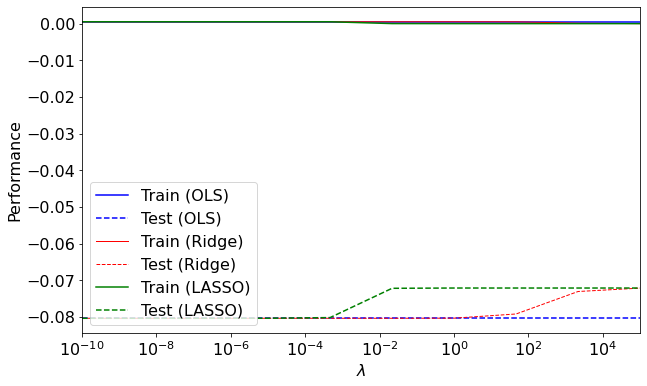

In [41]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_errors_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_errors_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_errors_ridge,'r',label='Train (Ridge)',linewidth=1)
plt.semilogx(lmbdas, test_errors_ridge,'--r',label='Test (Ridge)',linewidth=1)
plt.semilogx(lmbdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_errors_lasso, '--g',label='Test (LASSO)')

fig = plt.gcf()
fig.set_size_inches(10.0, 6.0)

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
# plt.ylim([-0.1, 1.1])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('Performance',fontsize=16)
plt.tick_params(labelsize=16)
plt.show()